## Step 3.1.1–3.1.2: Load and Preprocess Image

### Loading and Preparing the Image  
**Purpose:**  
Load the target image for segmentation and prepare it for clustering.

**Actions Taken:**
- **Image Loading:** Read the image using `skimage.io.imread`, returning a NumPy array in RGB format with values in \[0, 255\].
- **Type Conversion:** Convert the image to floating-point format \([0.0, 1.0]\) using `img_as_float`, which is preferred for downstream numerical operations.
- **Optional Display:** Use `io.imshow` to preview the loaded image.

**Output:**  
- Image shape and dtype (e.g., `(H, W, 3)` and `float64`) are printed for verification.
- The image is visually displayed to confirm successful loading.

**Use Case:**  
Prepares the raw image for clustering by ensuring it has the appropriate format and data type.


Original: (801, 1200, 3) float64


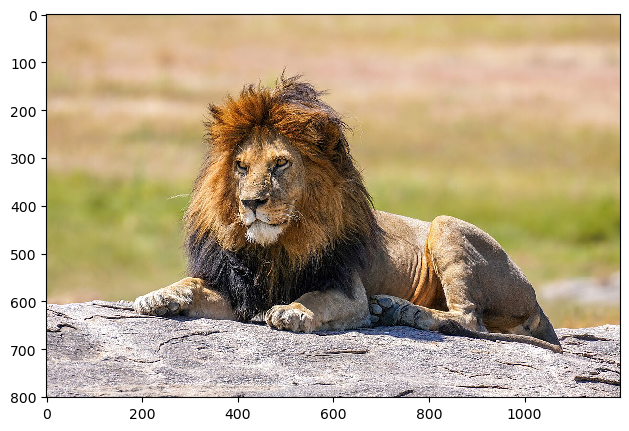

In [1]:
from skimage import io, img_as_float
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import median
from skimage.morphology import disk
import numpy as np
# Read the image; returns an array in RGB order, values in [0, 255]
img = io.imread('pic.jpg')

# Optionally convert to float in [0.0, 1.0]
img_float = img_as_float(img)

# img_float is now a NumPy array of shape (H, W, 3) with dtype float64
print("Original:", img_float.shape, img_float.dtype)
io.imshow(img, cmap='gray')
io.show()

## Step 3.1.2: Preprocess the Image (Grayscale & Resize)

### Image Preprocessing  
**Purpose:**  
Prepare the image for clustering by simplifying and reducing data size.

**Observed Effects:**  
- **Grayscale Conversion:** Reduces the image to a single intensity channel, simplifying feature space (especially useful if color is not essential for segmentation).
- **Resizing:** Reduces image dimensions by 50% using anti-aliasing to preserve visual quality while reducing computational load.

**Key Outputs:**  
- **Grayscale shape:** Matches original height × width, with single channel  
- **Resized shape:** Half the original resolution in both dimensions

**Use Case:**  
Grayscale simplifies clustering, and resizing speeds up computation while retaining segmentation-relevant structure.


In [7]:
gray = rgb2gray(img_float)
print("Grayscale:", gray.shape, gray.dtype)

Grayscale: (801, 1200) float64


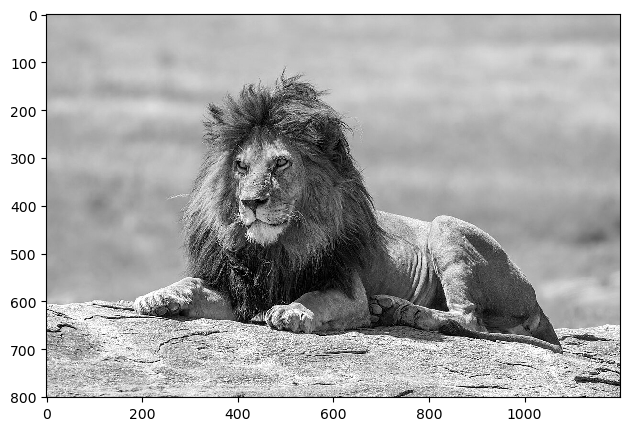

In [8]:
io.imshow(gray, cmap='gray')
io.show()

Resized: (400, 600) float64


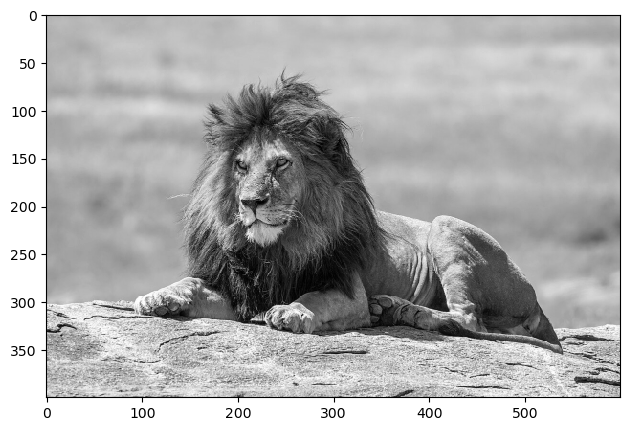

In [13]:
h, w = gray.shape
small = resize(gray, (h // 2, w // 2), anti_aliasing=True)
print("Resized:", small.shape, small.dtype)
io.imshow(small, cmap='gray')
io.show()

## Step 3.1.2 (continued): Denoising the Image

### Median Filtering  
**Purpose:**  
Remove small-scale noise while preserving edges using a median filter.

**Observed Effects:**  
- Reduces speckle and salt-and-pepper noise  
- Preserves important structural details (e.g., edges, lines)

**Key Parameter:**  
- **Disk radius:** 3 (defines neighborhood for median filtering)

**Use Case:**  
Prepares a cleaner input for clustering by smoothing irrelevant pixel-level variations.


Denoised: (400, 600) float64


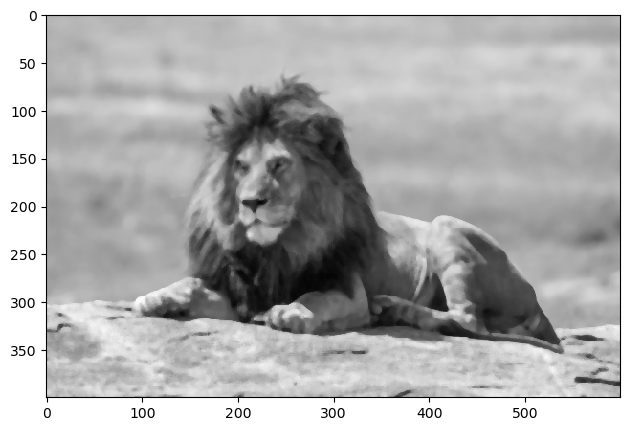

In [14]:
denoised = median(small, disk(3))
print("Denoised:", denoised.shape, denoised.dtype)
io.imshow(denoised, cmap='gray')
io.show()

## Step 3.1.3: Convert Image to Feature Vectors

### Feature Vector Preparation  
**Purpose:**  
Reshape the image so each pixel becomes a data point for clustering.

**Actions Taken:**  
- Convert the 2D image into a 1D array where each row is a pixel intensity value  
- Reshape using `ravel()` and `np.newaxis` to ensure compatibility with clustering algorithms like K-means

**Result:**  
- Final shape: `(num_pixels, 1)`  
- Suitable input format for unsupervised clustering algorithms

**Use Case:**  
Transforms spatial image data into a format interpretable by machine learning models.

In [50]:
import numpy as np
pic = denoised
h, w = pic.shape
X = pic.reshape(-1, 1)  
X = pic.ravel()[:, np.newaxis]


## Step 3.1.4–3.1.6: K-means Clustering & Centroid Extraction

### Clustering with K-means  
**Purpose:**  
Segment the image by grouping similar pixels into distinct clusters using the K-means algorithm.

**Actions Taken:**
- **Cluster Count Selection (K):** Chose `K = 3` based on expected number of distinct regions
- **Model Fitting:** Applied K-means on the reshaped pixel data to group pixels into clusters
- **Centroid Extraction:** Obtained the mean intensity of each cluster (i.e., the centroid values)

**Output:**
- `centers`: Array of cluster centroid intensities  
- `labels`: A 2D label map assigning each pixel to a cluster (reshaped to match image dimensions)

**Visualization:**
- A bar chart displays the intensity of each cluster centroid, helping understand the segmentation's contrast levels

**Use Case:**  
Forms the core of unsupervised segmentation, where pixels with similar intensity are grouped into the same region.


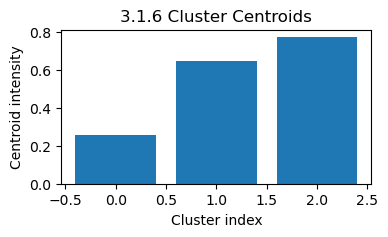

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
centers = kmeans.cluster_centers_.flatten()
labels = kmeans.labels_.reshape(h, w)

# Visualize centroids
plt.figure(figsize=(4,2))
plt.bar(range(k), centers)
plt.xlabel('Cluster index')
plt.ylabel('Centroid intensity')
plt.title('3.1.6 Cluster Centroids')
plt.show()

## Step 3.1.7: Create Segmented Image (Label Map)

### Label-Based Visualization  
**Purpose:**  
Display the clustering result by visualizing each cluster as a distinct region using a color-coded label map.

**Observed Effects:**  
- Each pixel is colored based on its assigned cluster label  
- Regions with similar pixel intensity are grouped visually  
- A qualitative colormap (`tab20`) highlights distinct segments clearly

**Visualization Type:**  
- Cluster **label map** rather than the actual centroid-based reconstruction  
- Does not preserve original intensity — purely for visual separation

**Use Cas**


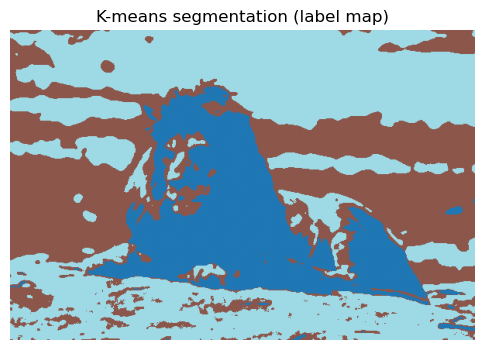

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(labels, cmap='tab20')   # any qualitative colormap works
plt.axis('off')
plt.title('K-means segmentation (label map)')
plt.show()


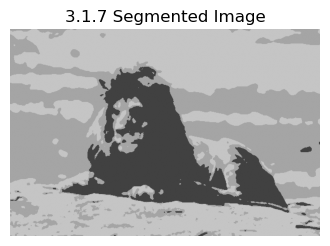

In [ ]:
seg_flat = centers[kmeans.labels_]
segmented = seg_flat.reshape(h, w)

# Visualize segmented image
plt.figure(figsize=(4,4))
plt.imshow(segmented, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('3.1.7 Segmented Image')
plt.show()

## Step 3.1.8: Generate and Save Segmented Image

### Reconstruct Image Using Cluster Centroids  
**Purpose:**  
Convert the label map into a grayscale image by replacing each pixel with its cluster's centroid intensity.

**Observed Effects:**  
- Creates a visually meaningful segmented version of the original image  
- Smooths regions by assigning uniform intensity within each cluster

**Output:**  
- Segmented image is saved as a `.png` file (`segmented_k3.png`)

**Use Case:**  
Useful for saving and sharing the results of unsupervised segmentation in a compact and interpretable form.


In [ ]:
filename = f'segmented_k{k}.png'
plt.imsave(filename, segmented, cmap='gray')
print(f"Saved segmented image as '{filename}'")

Saved segmented image as 'segmented_k3.png'


## Step 3.1.9: Experiment with Cluster Settings

### Parameter Sensitivity Analysis  
**Purpose:**  
Explore how different values of **K** and initialization methods affect segmentation results.

**Parameters Tested:**
- **Cluster counts:** 2, 3, 4  
- **Initializations:** `'k-means++'`, `'random'`

**Visualization:**
- A grid of segmentations shows the impact of each combination  
- Allows qualitative comparison of segment stability, boundaries, and convergence

**Use Case:**  
Identify optimal cluster count and initialization method for better segmentation performance on a given image.

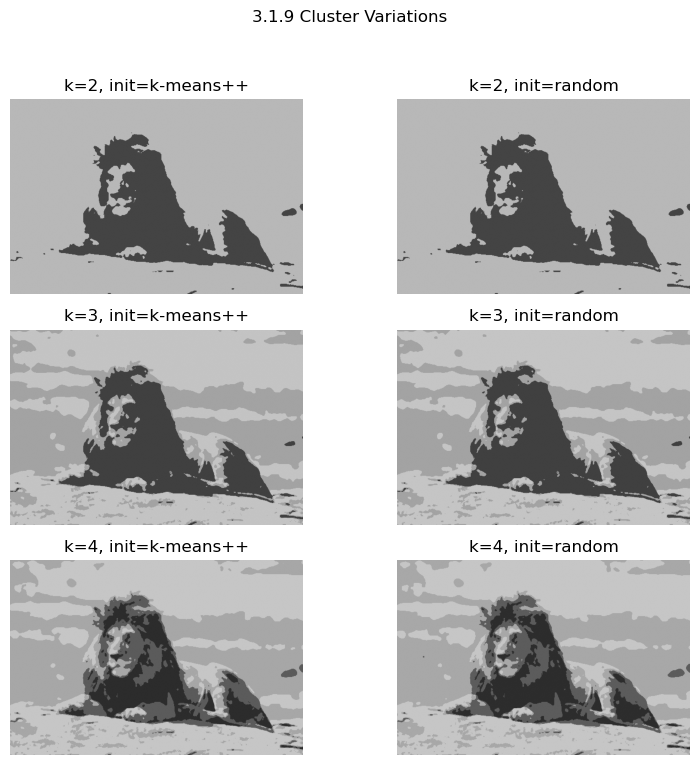

In [55]:
# === 3.1.9: Experiment with different cluster settings ===
ks = [2, 3, 4]
inits = ['k-means++', 'random']
fig, axes = plt.subplots(len(ks), len(inits), figsize=(8, 8))
for i, k_try in enumerate(ks):
    for j, init_method in enumerate(inits):
        km = KMeans(n_clusters=k_try, init=init_method, n_init=10, random_state=0).fit(X)
        seg = km.cluster_centers_.flatten()[km.labels_].reshape(h, w)
        ax = axes[i, j]
        ax.imshow(seg, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'k={k_try}, init={init_method}')
        ax.axis('off')
plt.suptitle('3.1.9 Cluster Variations')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

c:\Users\benje\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


ValueError: cannot reshape array of size 200 into shape (400,600)